# 第７回演習：機械学習の基礎

今回の演習では以下を学びます．

- データの前処理(欠損値補完、標準化)
- 複数のモデルの構築と比較
- 交差検証による性能評価
- 学習曲線の可視化と過学習の観察

Google Colabの動作確認（ローカルで実行している場合は飛ばして良い）

-    ページ上部のタブから「ランタイム」>「ランタイムのタイプを変更」> 「CPU」を選択してください
-    一つ下のコード群（コードセルと呼びます）をダブルクリックで選択
-    今日の日付を入力
-    shift+enter(return) or 左上の三角ボタンを押下して実行


In [ ]:
import sys
import torch

date = "2025/11/17"
print(f"実施日: {date}")

print(f"\n📌 Pythonバージョン: {sys.version.split()[0]}")
print(f"📌 PyTorchバージョン: {torch.__version__}")

# GPU利用可能か確認
if torch.cuda.is_available():
    print(f"✅ GPU利用可能: {torch.cuda.get_device_name(0)}")
    print(
        f"   GPUメモリ: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB"
    )
    device = "cuda"
else:
    print("⚠️  GPUが利用できません。CPUで実行します。")
    device = "cpu"

実施日: 2025/11/17

📌 Pythonバージョン: 3.12.12
📌 PyTorchバージョン: 2.8.0+cu126
⚠️  GPUが利用できません。CPUで実行します。


In [ ]:
# ライブラリのインポート
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

warnings.filterwarnings("ignore")

# 日本語フォントの設定（必要に応じて）
plt.rcParams["font.sans-serif"] = ["DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

# グラフのスタイル設定
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# 1. 回帰タスク

この演習では，糖尿病患者442名に関するデータセットを使用します．
入力変数として，基礎項目（age, sex, body mass index, average blood pressure）と6つの血液検査項目を与え，1年後の進行状況を予測します．

In [ ]:
# データの読み込み
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target

# データフレームに変換（可視化のため）
df_diabetes = pd.DataFrame(X_diabetes, columns=diabetes.feature_names)
df_diabetes["target"] = y_diabetes

print("\nデータの概要")
print(f"データ形状: {df_diabetes.shape}")
print("\n最初の3行:")
print(df_diabetes.head(3))

print("\n基本統計量:")
print(df_diabetes.describe())


データの概要
データ形状: (442, 11)

最初の3行:
        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  

基本統計量:
                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665608e-02 -3.424784e-02   
50%    5.383060e

学習の安定化のために入力データに対し，平均0，標準偏差が1になるように変換します．（標準化と言います）

In [ ]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_diabetes, y_diabetes, test_size=0.2, random_state=42
)

print(f"\n訓練データ: {X_train_reg.shape}")
print(f"テストデータ: {X_test_reg.shape}")

# 標準化
print("\nデータの標準化")
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print("標準化前の統計量（訓練データ）:")
print(
    f"  平均: {X_train_reg[:, 0].mean():.4f}, 標準偏差: {X_train_reg[:, 0].std():.4f}"
)
print("標準化後の統計量（訓練データ）:")
print(
    f"  平均: {X_train_reg_scaled[:, 0].mean():.4f}, 標準偏差: {X_train_reg_scaled[:, 0].std():.4f}"
)


訓練データ: (353, 10)
テストデータ: (89, 10)

データの標準化
標準化前の統計量（訓練データ）:
  平均: 0.0014, 標準偏差: 0.0463
標準化後の統計量（訓練データ）:
  平均: 0.0000, 標準偏差: 1.0000


講義でも扱った線形回帰モデル，決定木モデル（2種），サポートベクトルマシンを用いて学習を行います

In [ ]:
# 回帰モデルの定義
regression_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=5),
    "Random Forest": RandomForestRegressor(
        n_estimators=100, random_state=42, max_depth=5
    ),
    "SVM": SVR(kernel="rbf", C=1.0, epsilon=0.1),
}

# モデルの訓練と評価
regression_results = {}

for name, model in regression_models.items():
    print(f"\n--- {name} ---")

    # モデルの訓練
    model.fit(X_train_reg_scaled, y_train_reg)

    # 予測
    y_pred_train = model.predict(X_train_reg_scaled)
    y_pred_test = model.predict(X_test_reg_scaled)

    # 評価指標の計算
    train_mse = mean_squared_error(y_train_reg, y_pred_train)
    test_mse = mean_squared_error(y_test_reg, y_pred_test)
    train_r2 = r2_score(y_train_reg, y_pred_train)
    test_r2 = r2_score(y_test_reg, y_pred_test)

    regression_results[name] = {
        "train_mse": train_mse,
        "test_mse": test_mse,
        "train_r2": train_r2,
        "test_r2": test_r2,
    }

    print(f"訓練データ - MSE: {train_mse:.2f}, R²: {train_r2:.4f}")
    print(f"テストデータ - MSE: {test_mse:.2f}, R²: {test_r2:.4f}")


--- Linear Regression ---
訓練データ - MSE: 2868.55, R²: 0.5279
テストデータ - MSE: 2900.19, R²: 0.4526

--- Decision Tree ---
訓練データ - MSE: 2013.68, R²: 0.6686
テストデータ - MSE: 3526.02, R²: 0.3345

--- Random Forest ---
訓練データ - MSE: 1575.52, R²: 0.7407
テストデータ - MSE: 2885.59, R²: 0.4554

--- SVM ---
訓練データ - MSE: 5061.81, R²: 0.1670
テストデータ - MSE: 4332.74, R²: 0.1822


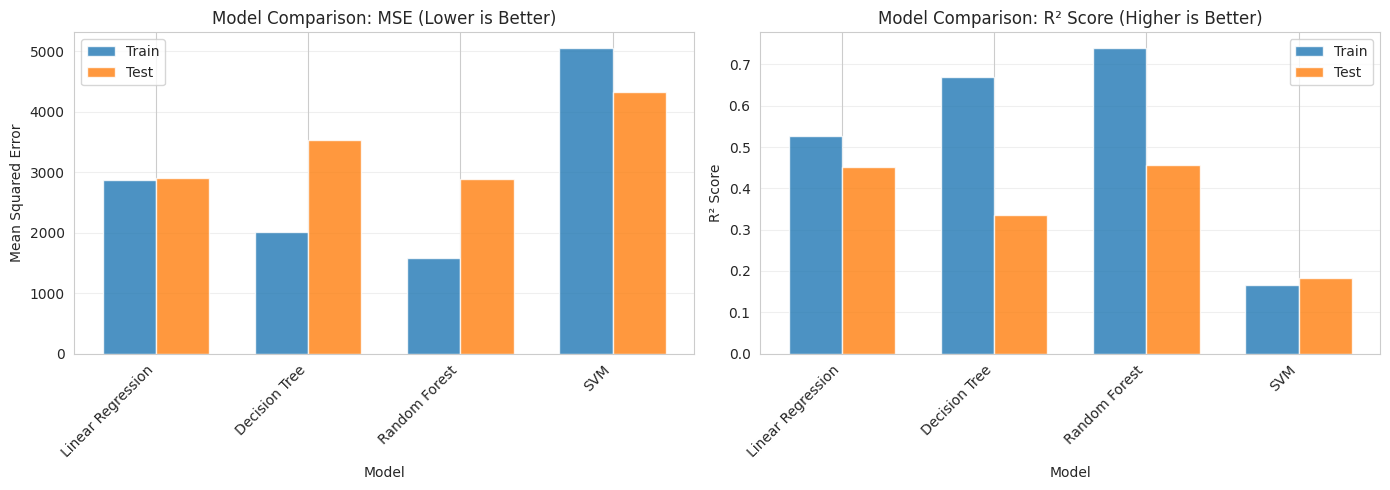

In [ ]:
# 結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_names = list(regression_results.keys())
train_mses = [regression_results[name]["train_mse"] for name in model_names]
test_mses = [regression_results[name]["test_mse"] for name in model_names]
train_r2s = [regression_results[name]["train_r2"] for name in model_names]
test_r2s = [regression_results[name]["test_r2"] for name in model_names]

x_pos = np.arange(len(model_names))
width = 0.35

# MSEの比較
axes[0].bar(x_pos - width / 2, train_mses, width, label="Train", alpha=0.8)
axes[0].bar(x_pos + width / 2, test_mses, width, label="Test", alpha=0.8)
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Mean Squared Error")
axes[0].set_title("Model Comparison: MSE (Lower is Better)")
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_names, rotation=45, ha="right")
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# R²スコアの比較
axes[1].bar(x_pos - width / 2, train_r2s, width, label="Train", alpha=0.8)
axes[1].bar(x_pos + width / 2, test_r2s, width, label="Test", alpha=0.8)
axes[1].set_xlabel("Model")
axes[1].set_ylabel("R² Score")
axes[1].set_title("Model Comparison: R² Score (Higher is Better)")
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(model_names, rotation=45, ha="right")
axes[1].legend()
axes[1].axhline(y=0, color="k", linestyle="--", linewidth=0.5)
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("regression_model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

# 2. 交差検証による性能評価

先ほど学習に使用したモデルについて，交差検証を行います．

今回はデータセットを5分割した交差検証を行います．
先ほどの結果と比較してください．

In [ ]:
print("\nk-分割交差検証（k=5）")

# 交差検証の設定
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 各モデルで交差検証を実行
cv_results = {}

for name, model in regression_models.items():
    print(f"\n--- {name} ---")

    # 交差検証スコアの計算（負のMSEを使用）
    cv_scores_mse = -cross_val_score(
        model, X_train_reg_scaled, y_train_reg, cv=cv, scoring="neg_mean_squared_error"
    )

    # 交差検証スコアの計算（R²）
    cv_scores_r2 = cross_val_score(
        model, X_train_reg_scaled, y_train_reg, cv=cv, scoring="r2"
    )

    cv_results[name] = {"mse_scores": cv_scores_mse, "r2_scores": cv_scores_r2}

    print(f"MSE: {cv_scores_mse.mean():.2f} (+/- {cv_scores_mse.std():.2f})")
    print(f"R²:  {cv_scores_r2.mean():.4f} (+/- {cv_scores_r2.std():.4f})")
    print(f"各分割のMSE: {cv_scores_mse}")


k-分割交差検証（k=5）

--- Linear Regression ---
MSE: 3074.14 (+/- 265.19)
R²:  0.4804 (+/- 0.0409)
各分割のMSE: [2848.75070009 3221.81099199 2813.57235224 2965.89557671 3520.68069731]

--- Decision Tree ---
MSE: 4764.39 (+/- 847.57)
R²:  0.1966 (+/- 0.1366)
各分割のMSE: [3602.21492852 5364.75781129 4993.26624102 3989.33109519 5872.38164753]

--- Random Forest ---
MSE: 3441.39 (+/- 215.87)
R²:  0.4159 (+/- 0.0622)
各分割のMSE: [3212.80635268 3794.86990902 3328.43046179 3288.83818955 3581.98892671]

--- SVM ---
MSE: 5368.33 (+/- 794.69)
R²:  0.1003 (+/- 0.0649)
各分割のMSE: [5470.91554561 5932.81862012 4110.75507585 4931.26561394 6395.91781182]


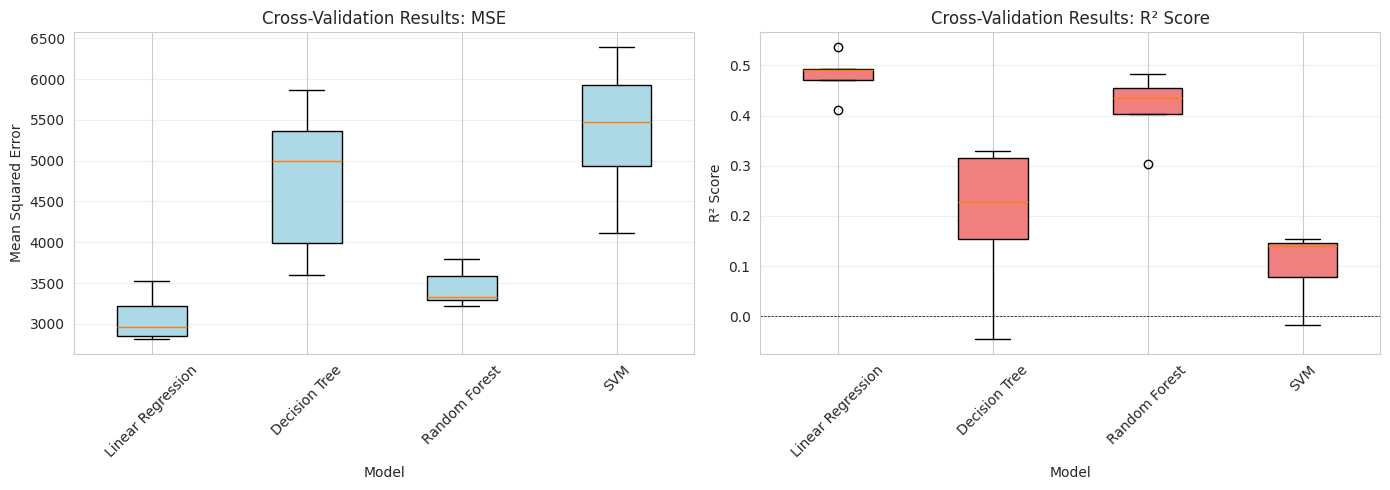

In [ ]:
# 交差検証結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MSEのボックスプロット
mse_data = [cv_results[name]["mse_scores"] for name in model_names]
bp1 = axes[0].boxplot(mse_data, labels=model_names, patch_artist=True)
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Mean Squared Error")
axes[0].set_title("Cross-Validation Results: MSE")
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(axis="y", alpha=0.3)

for patch in bp1["boxes"]:
    patch.set_facecolor("lightblue")

# R²スコアのボックスプロット
r2_data = [cv_results[name]["r2_scores"] for name in model_names]
bp2 = axes[1].boxplot(r2_data, labels=model_names, patch_artist=True)
axes[1].set_xlabel("Model")
axes[1].set_ylabel("R² Score")
axes[1].set_title("Cross-Validation Results: R² Score")
axes[1].tick_params(axis="x", rotation=45)
axes[1].axhline(y=0, color="k", linestyle="--", linewidth=0.5)
axes[1].grid(axis="y", alpha=0.3)

for patch in bp2["boxes"]:
    patch.set_facecolor("lightcoral")

plt.tight_layout()
plt.savefig("cross_validation_results.png", dpi=150, bbox_inches="tight")
plt.show()

# 3. 学習曲線の可視化と過学習の観察

In [ ]:
def plot_learning_curve(estimator, X, y, title, cv=5):
    """
    学習曲線を描画する関数
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring="neg_mean_squared_error",
    )

    # 負のMSEを正のMSEに変換
    train_scores = -train_scores
    test_scores = -test_scores

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    plt.title(title)
    plt.legend(loc="best")
    plt.grid(alpha=0.3)

    return plt

学習曲線を作成中: Linear Regression
学習曲線を作成中: Decision Tree
学習曲線を作成中: Random Forest
学習曲線を作成中: SVM


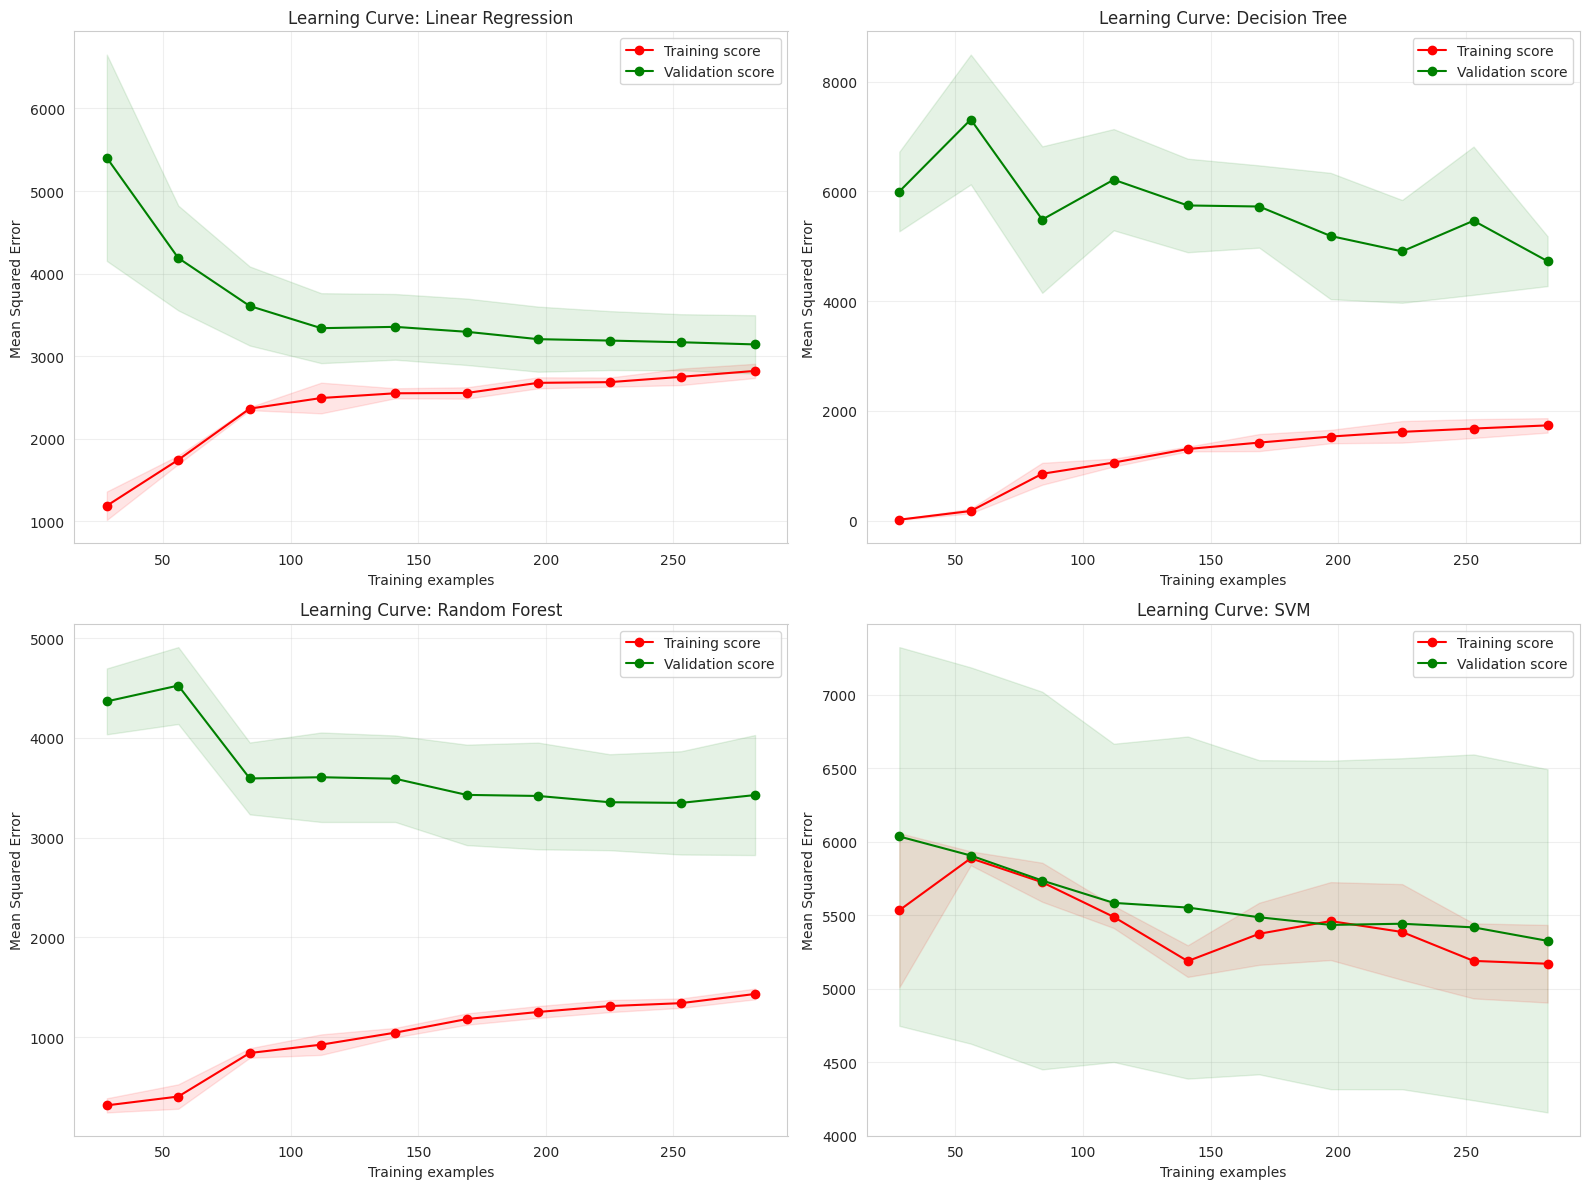

In [ ]:
# 各モデルの学習曲線を描画
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (name, model) in enumerate(regression_models.items()):
    print(f"学習曲線を作成中: {name}")

    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train_reg_scaled,
        y_train_reg,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring="neg_mean_squared_error",
    )

    # 負のMSEを正のMSEに変換
    train_scores = -train_scores
    test_scores = -test_scores

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes[idx].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[idx].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[idx].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[idx].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Validation score"
    )

    axes[idx].set_xlabel("Training examples")
    axes[idx].set_ylabel("Mean Squared Error")
    axes[idx].set_title(f"Learning Curve: {name}")
    axes[idx].legend(loc="best")
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("learning_curves.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# 過学習の分析
print("\n過学習の観察")
print("\n各モデルの訓練スコアと検証スコアの差（最終時点）:")

for name, model in regression_models.items():
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train_reg_scaled,
        y_train_reg,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring="neg_mean_squared_error",
    )

    train_scores = -train_scores
    test_scores = -test_scores

    final_train_score = np.mean(train_scores[-1])
    final_test_score = np.mean(test_scores[-1])
    gap = final_test_score - final_train_score

    print(f"\n{name}:")
    print(f"  訓練スコア: {final_train_score:.2f}")
    print(f"  検証スコア: {final_test_score:.2f}")
    print(f"  差分: {gap:.2f}")

    if gap > final_train_score * 0.3:
        print("  → 過学習の傾向が見られます")
    elif gap < final_train_score * 0.1:
        print("  → 良好な汎化性能です")
    else:
        print("  → 適度な汎化性能です")


過学習の観察

各モデルの訓練スコアと検証スコアの差（最終時点）:

Linear Regression:
  訓練スコア: 2821.93
  検証スコア: 3142.48
  差分: 320.54
  → 適度な汎化性能です

Decision Tree:
  訓練スコア: 1736.82
  検証スコア: 4729.34
  差分: 2992.52
  → 過学習の傾向が見られます

Random Forest:
  訓練スコア: 1434.05
  検証スコア: 3426.83
  差分: 1992.77
  → 過学習の傾向が見られます

SVM:
  訓練スコア: 5168.89
  検証スコア: 5324.68
  差分: 155.78
  → 良好な汎化性能です


# 4. 分類タスク

同様のことを分類タスクでも行ってみます．

今回は，ウィスコンシン大学の乳がん診断データセット(Wisconsin Diagnostic Breast Cancer, WDBC)を使用します．このデータセットは，569名の患者データを含み，30個の腫瘍細胞の画像から計算された特徴から，その腫瘍が良性か悪性を分類します．

In [ ]:
# データの読み込み
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

print("\nデータの概要")
print(f"データ形状: {X_cancer.shape}")
print(f"クラス: {cancer.target_names}")
print(f"クラスの分布: {np.bincount(y_cancer)}")

# データの分割
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

# 標準化
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print(f"\n訓練データ: {X_train_clf_scaled.shape}")
print(f"テストデータ: {X_test_clf_scaled.shape}")

# 分類モデルの定義
classification_models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=5),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, random_state=42, max_depth=5
    ),
    "SVM": SVC(kernel="rbf", C=1.0, random_state=42),
}


データの概要
データ形状: (569, 30)
クラス: ['malignant' 'benign']
クラスの分布: [212 357]

訓練データ: (455, 30)
テストデータ: (114, 30)


In [ ]:

classification_results = {}

for name, model in classification_models.items():
    print(f"\n--- {name} ---")

    # モデルの訓練
    model.fit(X_train_clf_scaled, y_train_clf)

    # 予測
    y_pred_train = model.predict(X_train_clf_scaled)
    y_pred_test = model.predict(X_test_clf_scaled)

    # 評価指標の計算
    train_acc = accuracy_score(y_train_clf, y_pred_train)
    test_acc = accuracy_score(y_test_clf, y_pred_test)

    classification_results[name] = {"train_acc": train_acc, "test_acc": test_acc}

    print(f"訓練精度: {train_acc:.4f}")
    print(f"テスト精度: {test_acc:.4f}")

    #if name == "Random Forest":  # Random Forestの詳細な結果を表示
    print("\n分類レポート:")
    print(
        classification_report(
            y_test_clf, y_pred_test, target_names=cancer.target_names
        )
    )


--- Logistic Regression ---
訓練精度: 0.9890
テスト精度: 0.9825

分類レポート:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


--- Decision Tree ---
訓練精度: 0.9934
テスト精度: 0.9211

分類レポート:
              precision    recall  f1-score   support

   malignant       0.87      0.93      0.90        42
      benign       0.96      0.92      0.94        72

    accuracy                           0.92       114
   macro avg       0.91      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114


--- Random Forest ---
訓練精度: 0.9934
テスト精度: 0.9561

分類レポート:
              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        42
      benign       0.96      0.97      0.97        72


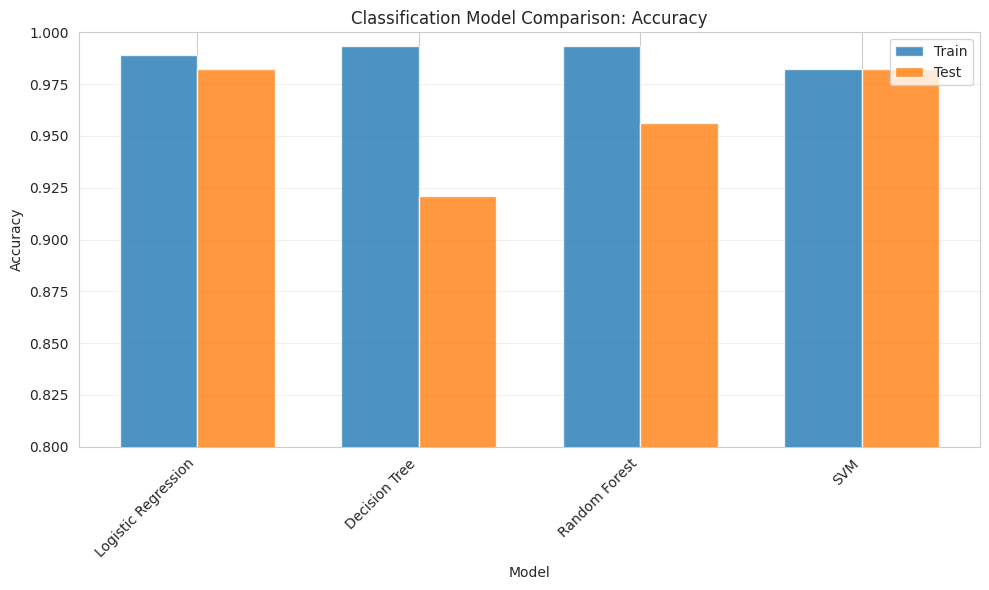


混同行列の可視化（Random Forest）


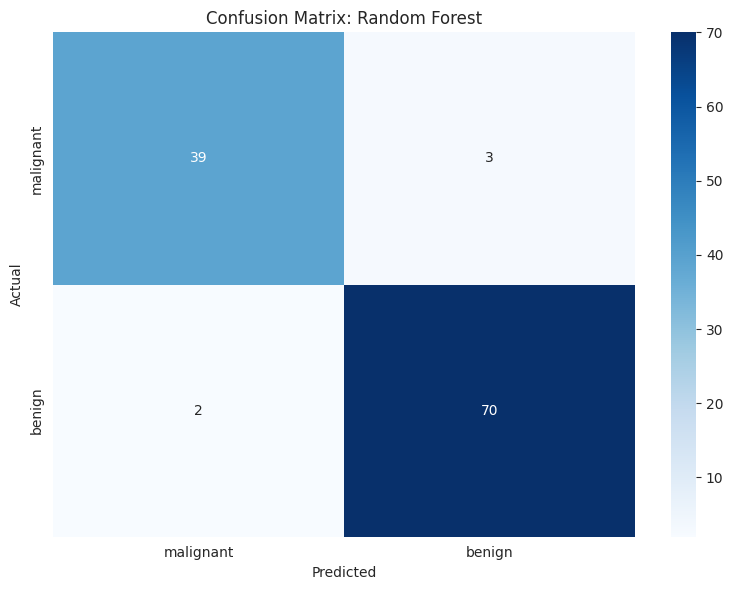

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

model_names_clf = list(classification_results.keys())
train_accs = [classification_results[name]["train_acc"] for name in model_names_clf]
test_accs = [classification_results[name]["test_acc"] for name in model_names_clf]

x_pos = np.arange(len(model_names_clf))
width = 0.35

ax.bar(x_pos - width / 2, train_accs, width, label="Train", alpha=0.8)
ax.bar(x_pos + width / 2, test_accs, width, label="Test", alpha=0.8)
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")
ax.set_title("Classification Model Comparison: Accuracy")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names_clf, rotation=45, ha="right")
ax.set_ylim([0.8, 1.0])
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("classification_model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

# 混同行列の可視化（Random Forestの例）
print("\n混同行列の可視化（Random Forest）")

rf_model = classification_models["Random Forest"]
y_pred_rf = rf_model.predict(X_test_clf_scaled)
cm = confusion_matrix(y_test_clf, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=cancer.target_names,
    yticklabels=cancer.target_names,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Random Forest")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
print(classification_report(
    y_test_clf, y_pred_rf, target_names=cancer.target_names
))

              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        42
      benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

